In [73]:
import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize
import os
from sklearn.model_selection import StratifiedKFold
import torch
import random
from torch.nn import Linear, LayerNorm, ReLU, Dropout
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer
from torch_geometric.data import Data, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import perf_counter
import optuna

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
print(device)

cpu


In [84]:

train = pd.read_json('../train.json', lines=True)

In [85]:
train=train.set_index("index")

In [86]:
train=train[train["signal_to_noise"]>=1]

In [87]:
train=train.assign(pair_prob=[np.load('../bpps/'+row['id']+'.npy') for index,row in train.iterrows()]) 

In [6]:
bpps_nb_mean = 0.077522 # mean of bpps_nb across all training data
bpps_nb_std = 0.08914  
error_mean_limit = 0.5

In [7]:
target_col = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

rna_dict    = {x:i for i, x in enumerate('ACGU')} #4
struct_dict = {x:i for i, x in enumerate('().')}  #3
loop_dict   = {x:i for i, x in enumerate('BEHIMSX')}#7

In [66]:
pair_threshold = 0.15
pair_prob = train["pair_prob"].values
def create_adj(index):
    mat = np.array(pair_prob[index])
    shape = mat.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            if(i==j):
                mat[i][j] = 1
                continue
            if(mat[i][j]>pair_threshold):
                mat[i][j]=1
            else:
                mat[i][j]=0
    return mat
def calc_error_mean(row):
    reactivity_error = row['reactivity_error']
    deg_error_Mg_pH10 = row['deg_error_Mg_pH10']
    deg_error_Mg_50C = row['deg_error_Mg_50C']

    return np.mean(np.abs(reactivity_error) +
                   np.abs(deg_error_Mg_pH10) + \
                   np.abs(deg_error_Mg_50C)) / 3

def calc_sample_weight(row):

    error_mean = calc_error_mean(row)
    if error_mean >= error_mean_limit:
        return 0.

    return 1. - error_mean / error_mean_limit
def weighted_mse_loss(prds, tgts, weight):
    return torch.mean(weight * (prds - tgts)**2)

def criterion(prds, tgts):
#     print(prds)
#     print(tgts)
    return (torch.sqrt(torch.nn.MSELoss()(prds, tgts)))

def add_edges(edge_index, edge_features, node1, node2, feature1, feature2):
    edge_index.append([node1, node2])
    edge_features.append(feature1)
    edge_index.append([node2, node1])
    edge_features.append(feature2)

def add_edges_between_base_nodes(edge_index, edge_features, node1, node2):
    edge_feature1 = [
        0, # is edge for paired nodes
        0, # is edge between codon node and base node
        0, # is edge between coden nodes
        1, # forward edge: 1, backward edge: -1
        1, # bpps if edge is for paired nodes
    ]
    edge_feature2 = [
        0, # is edge for paired nodes
        0, # is edge between codon node and base node
        0, # is edge between coden nodes
        -1, # forward edge: 1, backward edge: -1
        1, # bpps if edge is for paired nodes
    ]
    add_edges(edge_index, edge_features, node1, node2,
              edge_feature1, edge_feature2)

def add_edges_between_paired_nodes(edge_index, edge_features, node1, node2,
                                   bpps_value):
    edge_feature1 = [
        1, # is edge for paired nodes
        0, # is edge between codon node and base node
        0, # is edge between coden nodes
        0, # forward edge: 1, backward edge: -1
        bpps_value, # bpps if edge is for paired nodes
    ]
    edge_feature2 = [
        1, # is edge for paired nodes
        0, # is edge between codon node and base node
        0, # is edge between coden nodes
        0, # forward edge: 1, backward edge: -1
        bpps_value, # bpps if edge is for paired nodes
    ]
    add_edges(edge_index, edge_features, node1, node2,
              edge_feature1, edge_feature2)

def add_edges_between_codon_nodes(edge_index, edge_features, node1, node2):
    edge_feature1 = [
        0, # is edge for paired nodes
        0, # is edge between codon node and base node
        1, # is edge between coden nodes
        1, # forward edge: 1, backward edge: -1
        0, # bpps if edge is for paired nodes
    ]
    edge_feature2 = [
        0, # is edge for paired nodes
        0, # is edge between codon node and base node
        1, # is edge between coden nodes
        -1, # forward edge: 1, backward edge: -1
        0, # bpps if edge is for paired nodes
    ]
    add_edges(edge_index, edge_features, node1, node2,
              edge_feature1, edge_feature2)

def add_edges_between_codon_and_base_node(edge_index, edge_features,
                                          node1, node2):
    edge_feature1 = [
        0, # is edge for paired nodes
        1, # is edge between codon node and base node
        0, # is edge between coden nodes
        0, # forward edge: 1, backward edge: -1
        0, # bpps if edge is for paired nodes
    ]
    edge_feature2 = [
        0, # is edge for paired nodes
        1, # is edge between codon node and base node
        0, # is edge between coden nodes
        0, # forward edge: 1, backward edge: -1
        0, # bpps if edge is for paired nodes
    ]
    add_edges(edge_index, edge_features, node1, node2,
              edge_feature1, edge_feature2)

def add_node(node_features, feature):
    node_features.append(feature)

def add_base_node(node_features, sequence, predicted_loop_type,
                  bpps_sum, bpps_nb):
    feature = [
        0, # is codon node
        sequence == 'A',
        sequence == 'C',
        sequence == 'G',
        sequence == 'U',
        predicted_loop_type == 'S',
        predicted_loop_type == 'M',
        predicted_loop_type == 'I',
        predicted_loop_type == 'B',
        predicted_loop_type == 'H',
        predicted_loop_type == 'E',
        predicted_loop_type == 'X',
        bpps_sum,
        bpps_nb,
    ]
    add_node(node_features, feature)

def add_codon_node(node_features):
    feature = [
        1, # is codon node
        0, # sequence == 'A',
        0, # sequence == 'C',
        0, # sequence == 'G',
        0, # sequence == 'U',
        0, # predicted_loop_type == 'S',
        0, # predicted_loop_type == 'M',
        0, # predicted_loop_type == 'I',
        0, # predicted_loop_type == 'B',
        0, # predicted_loop_type == 'H',
        0, # predicted_loop_type == 'E',
        0, # predicted_loop_type == 'X',
        0, # bpps_sum
        0, # bpps_nb
    ]
    add_node(node_features, feature)

    
def build_data(df, is_train):
    data = []
    for i in range(len(df)):
        targets = []
        node_features = []
        edge_features = []
        edge_index = []
        train_mask = []
        test_mask = []
        weights = []

        id = df.loc[i, 'id']
        path = os.path.join('../bpps', id + '.npy')
        bpps = np.load(path)
        bpps_sum = bpps.sum(axis=0)
        sequence = df.loc[i, 'sequence']
        structure = df.loc[i, 'structure']
        pair_info = match_pair(structure)
        predicted_loop_type = df.loc[i, 'predicted_loop_type']
        seq_length = df.loc[i, 'seq_length']
        seq_scored = df.loc[i, 'seq_scored']
        bpps_nb = (bpps > 0).sum(axis=0) / seq_length
        bpps_nb = (bpps_nb - bpps_nb_mean) / bpps_nb_std
        if is_train:
            sample_weight = calc_sample_weight(df.loc[i])

            reactivity = df.loc[i, 'reactivity']
            deg_Mg_pH10 = df.loc[i, 'deg_Mg_pH10']
            deg_Mg_50C = df.loc[i, 'deg_Mg_50C']

            for j in range(seq_length):
                if j < seq_scored:
                    targets.append([
                        reactivity[j],
                        deg_Mg_pH10[j],
                        deg_Mg_50C[j],
                        ])
                else:
                    targets.append([0, 0, 0])

        paired_nodes = {}
        for j in range(seq_length):
            add_base_node(node_features, sequence[j], predicted_loop_type[j],
                          bpps_sum[j], bpps_nb[j])

            if j + 1 < seq_length: # edge between current node and next node
                add_edges_between_base_nodes(edge_index, edge_features,
                                             j, j + 1)

            if pair_info[j] != -1:
                if pair_info[j] not in paired_nodes:
                    paired_nodes[pair_info[j]] = [j]
                else:
                    paired_nodes[pair_info[j]].append(j)

            train_mask.append(j < seq_scored)
            test_mask.append(True)
            if is_train:
                weights.append(sample_weight)

       
        for pair in paired_nodes.values():
            bpps_value = bpps[pair[0], pair[1]]
            add_edges_between_paired_nodes(edge_index, edge_features,
                                           pair[0], pair[1], bpps_value)

       
        codon_node_idx = seq_length - 1
        for j in range(seq_length):
            if j % 3 == 0:
                # add codon node
                add_codon_node(node_features)
                codon_node_idx += 1
                train_mask.append(False)
                test_mask.append(False)
                if is_train:
                    weights.append(0)
                    targets.append([0, 0, 0])

                if codon_node_idx > seq_length:
                    # add edges between adjacent codon nodes
                    add_edges_between_codon_nodes(edge_index, edge_features,
                                                  codon_node_idx - 1,
                                                  codon_node_idx)

            # add edges between codon node and base node
            add_edges_between_codon_and_base_node(edge_index, edge_features,
                                                  j, codon_node_idx)

        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_features = torch.tensor(edge_features, dtype=torch.float)

        if is_train:
            data.append(MyData(x=node_features, edge_index=edge_index,
                               edge_attr=edge_features,
                               train_mask=torch.tensor(train_mask),
                               weight=torch.tensor(weights, dtype=torch.float),
                               y=torch.tensor(targets, dtype=torch.float)))
        else:
            data.append(MyData(x=node_features, edge_index=edge_index,
                               edge_attr=edge_features,
                               test_mask=torch.tensor(test_mask)))

    return data

def np_onehot(x, max=54):
    return np.eye(max)[x]

In [9]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, (3,2))
        self.conv2 = nn.Conv2d(10, 10, (2,1))
        self.fc1 = nn.Linear(10 * 31, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 68)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = x.view(-1, 10 * 31)
        x = F.tanh(self.fc1(x))
#         x = F.dropout(x,0.2)
        x = F.tanh(self.fc2(x))
#         x = F.dropout(x,0.2)
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [10]:
if __name__ == '__main__':
    seed = 777
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    kf = StratifiedKFold(5, shuffle=True, random_state=seed)
    

In [11]:
sequence=train['sequence'].map(lambda seq: [rna_dict[x] for x in seq]).tolist()
struct = train['structure'].map(lambda seq: [struct_dict[x] for x in seq]).tolist()
loop   = train['predicted_loop_type'].map(lambda seq: [loop_dict[x] for x in seq]).tolist()

In [12]:
def get_train_item(index):
    data = []
    data.append(np.array(np_onehot(sequence[index],4)))
    data.append(np_onehot(loop[index],7))
    data.append(create_adj(index))
    return (data)

In [67]:
def get_folded_seq(index):
    final = []
    seq = sequence[index]
    if(len(seq)==107):
        seq = seq[0:68]
        final.append(seq[0:34])
        final.append(list(reversed(seq[34:68])))
    else:
        seq = seq[0:92]
        final.append(seq[0:46])
        final.append(list(reversed(seq[46:92])))
    return final

def get_folded_loop(index):
    final = []
    seq = loop[index]
    if(len(seq)==107):
        seq = seq[0:68]
        final.append(seq[0:34])
        final.append(list(reversed(seq[34:68])))
    else:
        seq = seq[0:92]
        final.append(seq[0:46])
        final.append(list(reversed(seq[46:92])))
    return final

def build_channel(index):    
    final = []
    for x,y in zip(get_folded_seq(index),get_folded_loop(index)):
        tmp = []
        for a,b in zip(x,y):
            tmp.append([a,b])
        final.append(tmp)
    return final

def get_one_hot(index,base,adj):
#     start = perf_counter()
#     end = perf_counter()
#     print(end-start)
#     print("num of paired: ",sum(adj[base]))
    seq = np.zeros((4,5))
    loops = np.zeros((4,8))
    j = 0
#     print(train.iloc[index]["pair_prob"][base])
    x = adj[base]
    for i in range(len(x)):
        if(j==3):
            break
        if(x[i]==1):
#             print(np_onehot(sequence[index][base]+1,5))
            seq[j]=(np_onehot(sequence[index][base]+1,5))
            loops[j]=(np_onehot(loop[index][base]+1,8))
            j+=1
#     print(j)
    return (seq,loops)
            

In [14]:
epochs = 15
net = CNN2D()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)
batch_size = 50

In [15]:
losses = []
for epoch in range(epochs):
    batch = []
    cnn_input = []
    results = []
    ys = []
    net.train()
    for x in tqdm(range(len(train))):
        optimizer.zero_grad()
        input_t=build_channel(x)
        batch.append(input_t)
        ys.append(train.iloc[x]["reactivity"])
        if(len(batch)%batch_size==batch_size-1):
            result = net(torch.Tensor(batch).to(device))
            loss = criterion(result, torch.Tensor(ys).to(device))
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            batch = []
            ys = []

  0%|                                                                                         | 0/2097 [00:00<?, ?it/s]c:\users\padideh\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|█████████████████████████████████████████████████████████████████████████████| 2097/2097 [00:03<00:00, 572.29it/s]


In [16]:
sum(losses)/len(losses)

0.35207722920273976

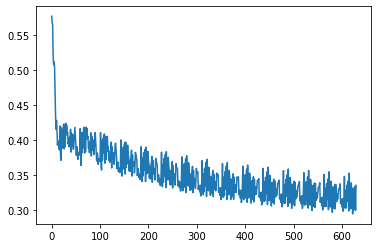

In [17]:
plt.plot(losses)

In [96]:
class DNN(nn.Module):
    def __init__(self,layer_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(52, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
        self.fc4 = nn.Linear(layer_size, layer_size)
        self.fc5 = nn.Linear(layer_size, layer_size)
        self.fc6 = nn.Linear(layer_size, layer_size)
        self.fc7 = nn.Linear(layer_size,1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
#         x = F.dropout(x,self.drop1)
#         x = self.fc2(x)
#         x = torch.tanh(x)
#         x = F.dropout(x,self.drop2)
#         x = self.fc3(x)
#         x = torch.tanh(x)
#         x = F.dropout(x,self.drop3)
#         x = self.fc4(x)
#         x = torch.tanh(x)
#         x = F.dropout(x,self.drop3)
#         x = self.fc5(x)
#         x = torch.tanh(x)
#         x = F.dropout(x,self.drop3)
        x = self.fc7(x)
        output =  x = torch.tanh(x)
        
        return output

In [88]:
def train_dnn(layer_size,alpha,batch_size):    
    dnn = DNN(layer_size)
    epochs = 1
    optimizer = torch.optim.Adam(net.parameters(), lr=alpha)
    losses = []
    input_t =[]
    for epoch in range(epochs):
        batch = []
        cnn_input = []
        results = []
        ys = []
        dnn.train()
        react = train["reactivity"].values
        for x in tqdm(range(len(train))):
            adj = create_adj(x)
            for y in range(train.iloc[x]["seq_scored"]):
    #             start = perf_counter()
                one_hot = get_one_hot(x,y,adj)

                for s in (one_hot[0]):
    #                 print(s)
                    input_t.extend(s)
                for l in (one_hot[1]):
    #                 print(l)
                    input_t.extend(l)
    #             end = perf_counter()
    #             print(end-start)
    #             print(input_t)
    #             break
    #             start=perf_counter()
                optimizer.zero_grad()
                batch.append(input_t)
                input_t = []
                ground = [react[x][y]]
                ys.append(ground)
    #             end = perf_counter()
    #             print(end-start)
    #             ys = np.asarray(ys).reshape((1,49))
                if(len(batch)%batch_size==batch_size-1):
                    result = dnn(torch.Tensor(batch).to(device))
                    loss = criterion(result, torch.Tensor(ys).to(device))
                    loss.backward()
                    optimizer.step()
                    losses.append(loss.item())
                    batch = []
                    ys = []
    return (sum(losses)/len(losses))

In [97]:
def objective(trial):
    layer_size = trial.suggest_int('layer_size', 30, 200)
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-3)
    batch_size = trial.suggest_int('batch_size', 500, 2000)
    results = train_dnn(layer_size,alpha,batch_size)
    return results

In [98]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2020-09-30 20:21:38,382] A new study created in memory with name: no-name-7f75eeb4-df2c-4db0-9ea0-e922377792e8
100%|██████████████████████████████████████████████████████████████████████████████| 2097/2097 [01:56<00:00, 17.94it/s]
[I 2020-09-30 20:23:35,320] Trial 0 finished with value: 0.5815710672792399 and parameters: {'layer_size': 182, 'alpha': 1.7079465913101342e-06, 'batch_size': 1335}. Best is trial 0 with value: 0.5815710672792399.
100%|██████████████████████████████████████████████████████████████████████████████| 2097/2097 [02:01<00:00, 17.32it/s]
[I 2020-09-30 20:25:36,443] Trial 1 finished with value: 0.5489849689030888 and parameters: {'layer_size': 62, 'alpha': 1.449342395286509e-06, 'batch_size': 720}. Best is trial 1 with value: 0.5489849689030888.
100%|██████████████████████████████████████████████████████████████████████████████| 2097/2097 [02:00<00:00, 17.38it/s]
[I 2020-09-30 20:27:37,106] Trial 2 finished with value: 0.5630329150108644 and parameters: {'layer_s

0.5827286225931034


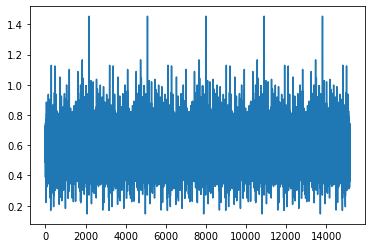

In [72]:
print(sum(losses)/len(losses))
plt.plot(losses)

In [ ]:
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gcn = ChebConv(2, node_hidden_channels, T)